In [6]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)  # makes figures larger by default

# Constraint Analysis with Casadi

* Why use Casadi?
    * Automatic differentiation (computes gradients for you)
    * Overkill for this application, but can be used in later stages of your design cycle when optimizations get more complex

In [31]:
def create_functions():
    """
    This function creates functions needed for the constraint analysis and returns
    them as a dictionary
    """
    
    def T_W_to_P_W(T_W, v, eta_p, eta_m):
        return v*T_W/(eta_p*eta_m)

    Cd0 = 0.08
    rho = 1.225
    eta_p = 0.8
    eta_m = 0.9
    k = 0.001
    g = 9.8
    V_stall = 2
    v_turn = 6  # turn at 4 m/s
    v_max = 6
    s_to = 5 # takeoff length
    s_l = 5 #landing length
    CL_max = 1.2
    mu = 0.1  # rolling friction coefficient
    roc = 5; # climb at 5 m/s
    
    
    
    def turn_P_W(W_S):
        q = 0.5*rho*(v_turn**2)
        n = 1.414 # load factor
        T_W_turn = q*Cd0/W_S + (n**2)*k*W_S/q
        return T_W_to_P_W(T_W_turn, v_turn, eta_p, eta_m)

    def takeoff_P_W(W_S):
        v = V_stall*1.2 # takeoff velocity
        T_W_to = (1.2**2)/(rho*g*s_to*CL_max)*W_S + 0.7*Cd0/CL_max + mu
        return T_W_to_P_W(T_W_to, v, eta_p, eta_m)
    
    def maxspeed_P_W(W_S):
        q = 0.5*rho*(v_max)**2
        T_W_ms = q*Cd0/W_S + k*W_S/q
        return T_W_to_P_W(T_W_ms, v_max, eta_p, eta_m)
    
    def landing_P_W(W_S):
        v = V_stall*1.3 # landing velocity
        T_W_l = (1.2**2)/(rho*g*s_l*CL_max)*W_S+ 0.7*Cd0/CL_max + mu
        return W_S/W_S*T_W_l

    def ceiling_P_W(W_S):
        Cl_ceiling = (3*Cd0/k)**.5
        v = (2*W_S/(rho*Cl_ceiling))
        return v/ (.866*eta_p*eta_m*g)
    
    def roc_P_W(W_S):
        Cl_roc = (3*Cd0/k)**.5
        v = (2*W_S/(rho*Cl_roc))**.5
        return (roc+ v/(.866*eta_p*eta_m*g))/(eta_p*eta_m)
    
    return {
        'turn_P_W': turn_P_W,
        'takeoff_P_W': takeoff_P_W,
        'maxspeed_P_W': maxspeed_P_W,
        'landing_P_W': landing_P_W,
        'ceiling_P_W': ceiling_P_W,
        'roc_P_W': roc_P_W
    }

In [32]:
def solve(funcs):
    """
    Takes a dictionary of functions and then solves the constraint analysis problem
    """
    
    # declare symbolic variables for the design vector we are solving for
    W_S = ca.SX.sym('W_S') # wing loading, weight/(wing area)
    P_W = ca.SX.sym('P_W') # power loading, power/weight
    solver = ca.nlpsol(
        'problem',  # name
        'ipopt',  # solver
        {  # problem details
            'x': ca.vertcat(W_S, P_W),  # decision variables/ design vector
            'f': P_W ,  # objective function
            'g': ca.vertcat(
                P_W - funcs['turn_P_W'](W_S),  # we subtract from P_W here to make g=0 when constraint is satisfied
                P_W - funcs['takeoff_P_W'](W_S),
                P_W - funcs['maxspeed_P_W'](W_S),
                P_W - funcs['landing_P_W'](W_S),
                P_W - funcs['ceiling_P_W'](W_S),
                P_W - funcs['roc_P_W'](W_S)
            )
        },
        {  # solver options
            'print_time': 0,
            'ipopt': {
                'sb': 'yes',
                'print_level': 0,
            }
        }
    )

    # Solve the problem
    res = solver(
        x0=[0.5, 0.5], # initial guess for (W_S, P_W)
        lbg=[0, 0, 0, 0, 0, 0],  # lower bound on constraints, 0, must meet power loading requirement
        ubg=[ca.inf, ca.inf, ca.inf, ca.inf, ca.inf, ca.inf],  # upper bound on constraints, none, can have excess power loading, inf
        lbx=[0, 0],  # lower bound on state, 0, cannot have negative wing loading, power loading
        ubx=[ca.inf, ca.inf],  # upper bound on state, inf
    )
    stats = solver.stats()
    
    # If the solver failed, raise an exception
    if not stats['success']:
        raise RuntimeError(stats['return_status'])
    return {
        'W_S': float(res['x'][0]),
        'P_W': float(res['x'][1]),
    }

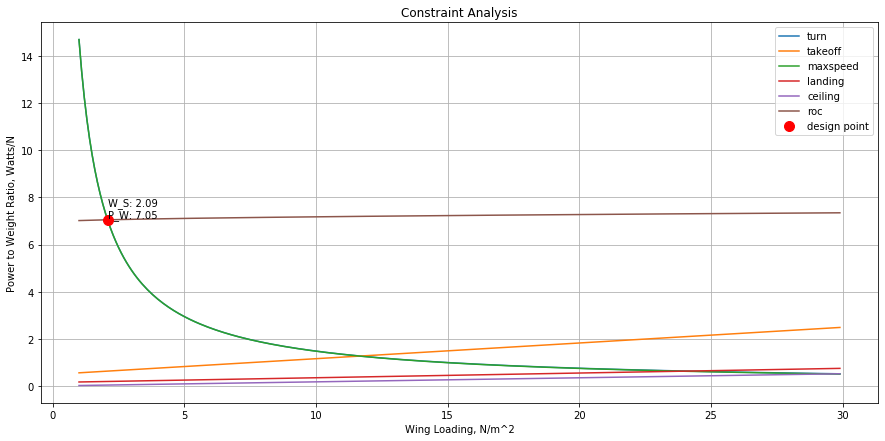

In [33]:
def constraint_analysis():
    """
    The main function that creates functions, solves the optimization problem, and then plots the constraint
    analysis diagram with the optimal design point labelled.
    """
    funcs = create_functions()
    opt_sol = solve(funcs)
    W_S_val = np.arange(1, 30, 0.1)
    plt.plot(W_S_val, funcs['turn_P_W'](W_S_val), label='turn')
    plt.plot(W_S_val, funcs['takeoff_P_W'](W_S_val), label='takeoff')
    plt.plot(W_S_val, funcs['maxspeed_P_W'](W_S_val), label='maxspeed')
    plt.plot(W_S_val, funcs['landing_P_W'](W_S_val), label='landing')
    plt.plot(W_S_val, funcs['ceiling_P_W'](W_S_val), label='ceiling')
    plt.plot(W_S_val, funcs['roc_P_W'](W_S_val), label='roc')
    
    plt.plot(opt_sol['W_S'], opt_sol['P_W'], 'r.', markersize=20, label='design point')
    plt.text(opt_sol['W_S'], opt_sol['P_W'] + 0.1, 'W_S: {W_S:0.2f}\nP_W: {P_W:0.2f}'.format(**opt_sol))
    plt.xlabel('Wing Loading, N/m^2')
    plt.ylabel('Power to Weight Ratio, Watts/N')
    plt.grid()
    plt.legend()
    plt.title('Constraint Analysis')
    
constraint_analysis()